### Analysis of the of the Polish parliamentary data

Aleksy Galkowski

This project focuses on members of the Polish parliament. In the following code, I scrape information on all 460 from a public governmental website. At the same time, I crawl for their names on Twitter and automatically save their Twitter handles if the resulting accounts are verified.

In [308]:
from bs4 import BeautifulSoup
from lxml import html
import requests as rq
import collections
import regex as re
import numpy as np
from datetime import datetime, date
import pandas as pd
import time

from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.wait import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.keys import Keys
from selenium.common.exceptions import TimeoutException

import tweepy
from tweepy_cred import BEARER_TOKEN

import string
import nltk 
from string import printable

import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
from stargazer.stargazer import Stargazer


##### 1. Declaring a dictionary for scraped data and twitter handles

In [2]:
# Members of parliament dictionary
parl = {
    'name': [None] * 460,
    'party': [None] * 460,
    'role_in_party': [None] * 460,
    'constituency': [None] * 460,
    'elected_votes': [None] * 460,
    'prev_terms_in_office': [None] * 460,
    'birth_date': [None] * 460,
    'age': [None] * 460,
    'born_city': [None] * 460,
    'education_level': [None] * 460,
    'profession': [None] * 460,
    'speeches_number': [None] * 460,
    'speeches_link': [None] * 460,
    'votes_participated': [None] * 460,
    'votes_link': [None] * 460,
    'twt_handle': [None] * 460
}

##### 2. Getting a list of links to active members of parliament

In [3]:
url = 'https://www.sejm.gov.pl/Sejm9.nsf/poslowie.xsp?type=A'
res = rq.get(url)
soup = BeautifulSoup(res.text, 'html.parser')
res.encoding = "UTF-8"

member_a_tags = soup.find_all("a", href=re.compile(r"Sejm9.nsf/posel.xsp"))
member_links = ['https://www.sejm.gov.pl/' + tag['href'] for tag in member_a_tags]

##### 3. Scraping information from each member's page, and simultaneously searching for their Twitter handles

In [1]:
# Starting two drivers - for the parliament website and Twitter

driver = webdriver.Chrome(executable_path='./chromedriver')
driver.get('https://www.sejm.gov.pl/Sejm9.nsf/poslowie.xsp?type=A')
wait = WebDriverWait(driver, 20)

driver2 = webdriver.Chrome(executable_path='./chromedriver')
driver2.get('http://twitter.com/explore')
wait2 = WebDriverWait(driver2, 20)

# Accessing each link from the members profile links list

for i, url in enumerate(member_links):
    print('Scraping ('+ str(i+1) + '/460)', '[', int(i/46*10)*'#', int(100-i/46*10)*'-', ']' + '\nLast person: ' + str(parl['twt_handle'][abs(i-1)]), end='\r')
  
    driver.get(url)
    res = rq.get(url)
    soup = BeautifulSoup(res.text, 'html.parser')
    res.encoding = "UTF-8"

    # Searching on Twitter as soon as the politician's name is known - to save time on loading
    name = soup.find('h1').text
    driver2.get('https://twitter.com/search?q=' + name.replace(' ', '%20') + '&f=user')

    # In the meantime, getting relevant information from the governmental website
    parl['name'][i] = name
    parl['party'][i] = soup.find('p', text = "Klub/koło:").find_next('p').text
    parl['constituency'][i] = re.sub(r'\xa0+', ' ', soup.find('p', {'id':'okreg'}).text)
    parl['elected_votes'][i] = int(soup.find('p', {'id':'lblGlosy'}).find_next_sibling().text)
    edu_lvl =  soup.find('p', {'id':'lblWyksztalcenie'})
    if  edu_lvl is not None:
        parl['education_level'][i] = edu_lvl.find_next('p').text
    parl['profession'][i] = soup.find('p', {'id':'lblZawod'}).find_next_sibling().text

    role_in_party = soup.find('p', {'id': 'p1'})
    if role_in_party is not None:
        parl['role_in_party'][i] = role_in_party.find_next_sibling().text
    else: 
        parl['role_in_party'][i] = np.nan

    prev_terms_in_office = soup.find('p', {'id':'lblStaz'}).find_next_sibling().text.split(', ')
    if (prev_terms_in_office[0] == 'brak'):
        parl['prev_terms_in_office'][i] = []
    else:
        parl['prev_terms_in_office'][i] = prev_terms_in_office

    birth = soup.find('p', {'id':'urodzony'}).text.split(', ')
    birth_date = datetime.strptime(birth[0], '%d-%m-%Y').date()
    parl['birth_date'][i] = birth_date
    parl['age'][i] = int((date.today() - datetime.strptime(birth[0], '%d-%m-%Y').date()).days/365)
    if (len(birth) == 2):
        parl['born_city'][i] = birth[1]
    else:
        parl['born_city'][i] = np.nan

    # Using Selenium to scrape dynamic elements from the governmental website
    driver.find_element(By.ID, 'wystapienia').click()
    wait.until(EC.presence_of_element_located((By.CSS_SELECTOR, "td.left")))
    driver.find_element(By.ID, 'glosowania').click()
    wait.until(EC.presence_of_element_located((By.LINK_TEXT, 'więcej...')))

    parl_activity_elements =  driver.find_elements(By.CSS_SELECTOR, "td.left")

    if (parl_activity_elements[0].text == 'Brak aktywności'):
        parl['speeches_number'][i] = 0
        parl['speeches_link'][i] = np.nan
    else:
        parl['speeches_number'][i] = int(re.findall('\d+', parl_activity_elements[0].text)[0])
        parl['speeches_link'][i] = parl_activity_elements[0].find_element(By.TAG_NAME, 'a').get_attribute('href')
    parl['votes_participated'][i] = re.findall('\d*\.?\d+%?', parl_activity_elements[1].text)[0]
    parl['votes_link'][i] = parl_activity_elements[2].find_element(By.TAG_NAME, 'a').get_attribute('href')

    # Searching for the name on Twitter with Selenium - saving Twitter handle if result of the name search is a verified account
    try:
        # wait for the loading element to appear
        WebDriverWait(driver, 5
        ).until(EC.presence_of_element_located((By.XPATH, '//*[@id="react-root"]/div/div/div[2]/main/div/div/div/div/div/div[3]/div/div/div')))
        # then wait for the element to disappear
        WebDriverWait(driver, 15
            ).until_not(EC.presence_of_element_located((By.XPATH, '//*[@id="react-root"]/div/div/div[2]/main/div/div/div/div/div/div[3]/div/div/div')))
    except TimeoutException:
        pass
    
    try:
        top_result = driver2.find_element(By.XPATH, '//*[@id="react-root"]/div/div/div[2]/main/div/div/div/div/div/div[3]/div/section/div/div/div[1]/div/div')
    except:
        parl['twt_handle'][i] = np.nan
    else:
        verified = top_result.find_elements(By.CSS_SELECTOR, 'svg[aria-label="Verified account"]')
        if(len(verified) > 0):
            parl['twt_handle'][i] = top_result.find_element(By.TAG_NAME, 'a').get_attribute('href').rsplit('/',1)[-1]
        else:
            parl['twt_handle'][i] = np.nan
    

##### 4. Saving *parl* dictonary to a dataframe and exporting to a CSV file

In [21]:
df = pd.DataFrame.from_dict(parl)
# df.to_csv('df.csv')

##### 5. Loading dataframe from CSV file

In [206]:
df = pd.read_csv('df.csv')
df

,Unnamed: 0,name,party,role_in_party,constituency,elected_votes,prev_terms_in_office,birth_date,age,born_city,education_level,profession,speeches_number,speeches_link,votes_participated,votes_link,twt_handle
0,0,Andrzej Adamczyk,Klub Parlamentarny Prawo i Sprawiedliwość,NaN,13 Kraków,29686,"['poseł V kadencji', 'poseł VI kadencji', 'pos...",1959-01-04,64,Krzeszowice,wyższe,parlamentarzysta,17,https://www.sejm.gov.pl//Sejm9.nsf/wypowiedzi....,95.44%,https://www.sejm.gov.pl//Sejm9.nsf/agent.xsp?s...,AMAdamczyk
1,1,Rafał Adamczyk,"Koalicyjny Klub Poselski Lewicy (Nowa Lewica, ...",NaN,32 Katowice,12148,[],1974-05-30,48,Dąbrowa Górnicza,wyższe,samorządowiec,383,https://www.sejm.gov.pl//Sejm9.nsf/wypowiedzi....,99.65%,https://www.sejm.gov.pl//Sejm9.nsf/agent.xsp?s...,NaN
2,2,Piotr Adamowicz,Klub Parlamentarny Koalicja Obywatelska - Plat...,NaN,25 Gdańsk,41795,[],1961-06-26,61,Elbląg,średnie ogólne,dziennikarz,62,https://www.sejm.gov.pl//Sejm9.nsf/wypowiedzi....,99.34%,https://www.sejm.gov.pl//Sejm9.nsf/agent.xsp?s...,NaN
3,3,Romuald Ajchler,"Koalicyjny Klub Poselski Lewicy (Nowa Lewica, ...",NaN,38 Piła,14438,"['poseł II kadencji', 'poseł III kadencji', 'p...",1949-01-19,74,Duszniki Wielkopolskie,średnie zawodowe,rolnik,63,https://www.sejm.gov.pl//Sejm9.nsf/wypowiedzi....,90.93%,https://www.sejm.gov.pl//Sejm9.nsf/agent.xsp?s...,NaN
4,4,Zbigniew Ajchler,Poseł niezrzeszony,NaN,38 Piła,6654,['poseł VIII kadencji'],1955-11-21,67,Szamotuły,wyższe,przedsiębiorca rolny,2,https://www.sejm.gov.pl//Sejm9.nsf/wypowiedzi....,85.10%,https://www.sejm.gov.pl//Sejm9.nsf/agent.xsp?s...,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
455,455,Ireneusz Zyska,Klub Parlamentarny Prawo i Sprawiedliwość,NaN,2 Wałbrzych,10688,['poseł VIII kadencji'],1969-08-05,53,Świebodzice,wyższe,radca prawny,45,https://www.sejm.gov.pl//Sejm9.nsf/wypowiedzi....,98.11%,https://www.sejm.gov.pl//Sejm9.nsf/agent.xsp?s...,Ireneusz_Zyska
456,456,Jacek Żalek,Klub Parlamentarny Prawo i Sprawiedliwość,NaN,24 Białystok,12141,"['poseł VI kadencji', 'poseł VII kadencji', 'p...",1973-01-13,50,Białystok,wyższe,poseł,6,https://www.sejm.gov.pl//Sejm9.nsf/wypowiedzi....,96.81%,https://www.sejm.gov.pl//Sejm9.nsf/agent.xsp?s...,JacekZalek
457,457,Bożena Żelazowska,"Klub Parlamentarny Koalicja Polska - PSL, UED,...",NaN,20 Warszawa,8665,[],1970-08-23,52,Chełm,wyższe,politolog,119,https://www.sejm.gov.pl//Sejm9.nsf/wypowiedzi....,98.32%,https://www.sejm.gov.pl//Sejm9.nsf/agent.xsp?s...,Bozenazelazowsk
458,458,Stanisław Żuk,Koło Poselskie Kukiz'15 - Demokracja Bezpośrednia,NaN,1 Legnica,7694,[],1954-10-01,68,Plimkaim,wyższe,menedżer,42,https://www.sejm.gov.pl//Sejm9.nsf/wypowiedzi....,96.89%,https://www.sejm.gov.pl//Sejm9.nsf/agent.xsp?s...,NaN


##### 6. Defining functions for getting Twitter data via tweepy

In [116]:
nltk.download('stopwords')
stopword = nltk.corpus.stopwords.words('english')
with open('polish_stopwords.txt') as file:
    polish_stopwords = [line.rstrip() for line in file]
stopword.extend(polish_stopwords)

def remove_punct(text):
    text  = "".join([char for char in text if char not in string.punctuation])
    # text = re.sub("[^{}]+".format(printable), "", text)
    text = re.sub('\ufe0f', '', text)
    text = re.sub('[0-9]+', '', text)
    text = re.sub(' +', ' ', text)
    return text

def tokenization(text):
    text = re.split('\W+', text)
    return text

def remove_stopwords(text):
    text = [word for word in text if word not in stopword]
    return text

def clean_tweets(tweets):
    word_list = remove_stopwords(tokenization(remove_punct(tweets).lower()))
    return word_list

def count_pis_instances(tweets):
    if (pd.isnull(tweets)):
        return np.nan
    arr = np.array(clean_tweets(tweets))
    count = np.count_nonzero(arr == 'pis')
    return count

def tweets_word_count (word_list):
    wordcount_df = pd.value_counts(np.array(word_list))
    most_used_words = wordcount_df.index[0:11]
    # top_word_used_count = wordcount_df.iloc[0]
    # return most_used_words, top_word_used_count
    return most_used_words

def get_last_100_tweets(twt_handle):
    user_id = api.get_user(username = twt_handle)['data']['id']
    tweets = api.get_users_tweets(id = user_id, max_results = 100, exclude='retweets', tweet_fields=['text'])
    try:
        tweets_text = [tweet['text'] for tweet in tweets['data']]
        tweets_corpus = ' '.join(tweets_text)
        return tweets_corpus
    except:
        return np.nan

def get_twitter_data(twt_handle):
    if(pd.isnull(twt_handle)):
        return np.nan, np.nan, np.nan, np.nan, np.nan
    user_id = api.get_user(username = twt_handle)['data']['id']
    public_metrics = api.get_user(username = twt_handle, user_fields ='public_metrics')['data']['public_metrics']
    tweets_count = public_metrics['tweet_count']
    follower_count = public_metrics['followers_count']  
    tweets = get_last_100_tweets(twt_handle)
    if pd.isnull(tweets):
        most_used_words = np.nan
        top_word_used_count = np.nan
    else:
        most_used_words, top_word_used_count = tweets_word_count(clean_tweets(tweets))
    # print(tweets_count, tweets, follower_count, most_used_words, top_word_used_count)

    return tweets_count, tweets, follower_count, most_used_words, top_word_used_count

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/aleksygalkowski/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


##### 7. Creating new columns with Twitter data by mapping the Twitter handles column with the get_twitter_data function 

In [102]:
api = tweepy.Client(bearer_token = BEARER_TOKEN,
                       return_type=dict,        # Return the response as a Python dictionary.
                       wait_on_rate_limit=True) # Wait once the rate limit is reached.

# Getting Twitter data in batches and saving them to a variable, to avoid losing all progress in case of an error

batch_size = 23
index = 391
while index < 460:
    print('index:', index)
    df_batch = pd.DataFrame()
    if (index + batch_size > 460):
        df_batch['twt_tweet_count'], df_batch['twt_last_100_tweets_corpus'], df_batch['twt_followers'], df_batch['twt_most_used_words'], df_batch['twt_most_used_word_instances'] = zip(*df['twt_handle'].iloc[index:460].map(get_twitter_data))
    else:
        df_batch['twt_tweet_count'], df_batch['twt_last_100_tweets_corpus'], df_batch['twt_followers'], df_batch['twt_most_used_words'], df_batch['twt_most_used_word_instances'] = zip(*df['twt_handle'].iloc[index: index+batch_size].map(get_twitter_data))
        df_twt = pd.concat([df_twt, df_batch], ignore_index=True)
    print(df_twt)
    index += batch_size


index: 391


Rate limit exceeded. Sleeping for 201 seconds.


     twt_tweet_count                         twt_last_100_tweets_corpus  \
0            15472.0  Odejście Jego Świątobliwości emerytowanego pap...   
1                NaN                                                NaN   
2                NaN                                                NaN   
3                NaN                                                NaN   
4                NaN                                                NaN   
..               ...                                                ...   
409           4817.0  @ArturMachnik @RADIO_REBELIANT Sprawa jest roz...   
410           4423.0  Australijski kard. George Pell,niesłusznie ska...   
411            735.0  Dzisiaj 10 stycznia. Węgiel jest, w domach cie...   
412            628.0  #SpotkanieNoworoczne Parlamentarnego Zespołu S...   
413           5545.0  @donaldtusk Żałosny, jak zwykle. Mimo wszystko...   

     twt_followers                                twt_most_used_words  \
0          12611.0  [odejś

##### 8. Saving / reading the Twitter data

Note: The Twitter data may likely be incomplete. 

My scraping algorithm searched for the full name of each of the politicians, and took the first result provided it was a verified account. This creates a potential problem of omitting some verified accounts which do not use their full name - especially common occurence among younger members of parliament.

Therefore, not all NaN values mean that a person does not have an account - it could be unverified, or could be missed by the algorithm.

In [346]:
# df_twt.to_csv('df_twt.csv')
df_twt = pd.read_csv('df_twt.csv')
print('Collected twt accounts:', len(df_twt.dropna()))
print('Rows without Twitter data:', 460-325)
df_twt

Collected twt accounts: 325
Rows without Twitter data: 135


,Unnamed: 0,twt_tweet_count,twt_last_100_tweets_corpus,twt_followers,twt_most_used_words,twt_most_used_word_instances
0,0,15472.0,Odejście Jego Świątobliwości emerytowanego pap...,12611.0,"['odejście', 'infrastruktury', 'httpstcorxhmew...",1.0
1,1,NaN,NaN,NaN,NaN,NaN
2,2,NaN,NaN,NaN,NaN,NaN
3,3,NaN,NaN,NaN,NaN,NaN
4,4,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
455,455,3355.0,Dear @KurtykaMichal congratulations❗️Good luck...,3711.0,"['️', 'mkisgovpl', 'morawieckim', 'oze', 'dzię...",22.0
456,456,8080.0,@miloszlodowski Dobry i serdeczny człowiek. Od...,18483.0,"['republikaniepl', 'adambielan', 'jacekdrzewis...",3.0
457,457,2070.0,Kolejne dobre wiadomości z Gminy Karczew. Wczo...,3736.0,"['nowepsl', 'pis', '️', 'tvpinfo', 'dziękuję',...",81.0
458,458,NaN,NaN,NaN,NaN,NaN


##### 9. Trimming redundant df_twt column and joining dataframes into one

In [3]:
# df_joined = pd.concat([df, df_twt.drop(columns=['Unnamed: 0'])], axis=1)
# df_joined
# df_joined.to_csv('df_joined.csv')
df_joined = pd.read_csv('df_joined.csv').drop(columns=['Unnamed: 0'])
df_joined

,name,female,party,role_in_party,constituency,elected_votes,prev_terms_in_office,birth_date,age,born_city,...,speeches_link,votes_participated,votes_link,twt_handle,twt_verified,twt_tweet_count,twt_last_100_tweets_corpus,twt_followers,twt_most_used_words,twt_most_used_word_instances
0,Andrzej Adamczyk,False,Klub Parlamentarny Prawo i Sprawiedliwość,NaN,13 Kraków,29686,"['poseł V kadencji', 'poseł VI kadencji', 'pos...",1959-01-04,64,Krzeszowice,...,https://www.sejm.gov.pl//Sejm9.nsf/wypowiedzi....,95.44%,https://www.sejm.gov.pl//Sejm9.nsf/agent.xsp?s...,AMAdamczyk,True,15472.0,Odejście Jego Świątobliwości emerytowanego pap...,12611.0,"['odejście', 'infrastruktury', 'httpstcorxhmew...",1.0
1,Rafał Adamczyk,False,"Koalicyjny Klub Poselski Lewicy (Nowa Lewica, ...",NaN,32 Katowice,12148,[],1974-05-30,48,Dąbrowa Górnicza,...,https://www.sejm.gov.pl//Sejm9.nsf/wypowiedzi....,99.65%,https://www.sejm.gov.pl//Sejm9.nsf/agent.xsp?s...,NaN,False,NaN,NaN,NaN,NaN,NaN
2,Piotr Adamowicz,False,Klub Parlamentarny Koalicja Obywatelska - Plat...,NaN,25 Gdańsk,41795,[],1961-06-26,61,Elbląg,...,https://www.sejm.gov.pl//Sejm9.nsf/wypowiedzi....,99.34%,https://www.sejm.gov.pl//Sejm9.nsf/agent.xsp?s...,NaN,False,NaN,NaN,NaN,NaN,NaN
3,Romuald Ajchler,False,"Koalicyjny Klub Poselski Lewicy (Nowa Lewica, ...",NaN,38 Piła,14438,"['poseł II kadencji', 'poseł III kadencji', 'p...",1949-01-19,74,Duszniki Wielkopolskie,...,https://www.sejm.gov.pl//Sejm9.nsf/wypowiedzi....,90.93%,https://www.sejm.gov.pl//Sejm9.nsf/agent.xsp?s...,NaN,False,NaN,NaN,NaN,NaN,NaN
4,Zbigniew Ajchler,False,Poseł niezrzeszony,NaN,38 Piła,6654,['poseł VIII kadencji'],1955-11-21,67,Szamotuły,...,https://www.sejm.gov.pl//Sejm9.nsf/wypowiedzi....,85.10%,https://www.sejm.gov.pl//Sejm9.nsf/agent.xsp?s...,NaN,False,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
455,Ireneusz Zyska,False,Klub Parlamentarny Prawo i Sprawiedliwość,NaN,2 Wałbrzych,10688,['poseł VIII kadencji'],1969-08-05,53,Świebodzice,...,https://www.sejm.gov.pl//Sejm9.nsf/wypowiedzi....,98.11%,https://www.sejm.gov.pl//Sejm9.nsf/agent.xsp?s...,Ireneusz_Zyska,True,3355.0,Dear @KurtykaMichal congratulations❗️Good luck...,3711.0,"['️', 'mkisgovpl', 'morawieckim', 'oze', 'dzię...",22.0
456,Jacek Żalek,False,Klub Parlamentarny Prawo i Sprawiedliwość,NaN,24 Białystok,12141,"['poseł VI kadencji', 'poseł VII kadencji', 'p...",1973-01-13,50,Białystok,...,https://www.sejm.gov.pl//Sejm9.nsf/wypowiedzi....,96.81%,https://www.sejm.gov.pl//Sejm9.nsf/agent.xsp?s...,JacekZalek,True,8080.0,@miloszlodowski Dobry i serdeczny człowiek. Od...,18483.0,"['republikaniepl', 'adambielan', 'jacekdrzewis...",3.0
457,Bożena Żelazowska,True,"Klub Parlamentarny Koalicja Polska - PSL, UED,...",NaN,20 Warszawa,8665,[],1970-08-23,52,Chełm,...,https://www.sejm.gov.pl//Sejm9.nsf/wypowiedzi....,98.32%,https://www.sejm.gov.pl//Sejm9.nsf/agent.xsp?s...,Bozenazelazowsk,True,2070.0,Kolejne dobre wiadomości z Gminy Karczew. Wczo...,3736.0,"['nowepsl', 'pis', '️', 'tvpinfo', 'dziękuję',...",81.0
458,Stanisław Żuk,False,Koło Poselskie Kukiz'15 - Demokracja Bezpośrednia,NaN,1 Legnica,7694,[],1954-10-01,68,Plimkaim,...,https://www.sejm.gov.pl//Sejm9.nsf/wypowiedzi....,96.89%,https://www.sejm.gov.pl//Sejm9.nsf/agent.xsp?s...,NaN,False,NaN,NaN,NaN,NaN,NaN


##### 10. Adding sex and twt_verified binary variables

In [138]:
# female = df['name'].map(lambda x: x.split()[0][-1] == 'a')
# df_joined.insert(1, 'female', female)

# df_joined.insert(17, 'twt_verified', df_joined['twt_handle'].apply(lambda x: not pd.isnull(x)))
# df_joined

# df_joined.to_csv('df_joined.csv')

,Unnamed: 0,name,female,party,role_in_party,constituency,elected_votes,prev_terms_in_office,birth_date,age,...,speeches_link,votes_participated,votes_link,twt_handle,twt_verified,twt_tweet_count,twt_last_100_tweets_corpus,twt_followers,twt_most_used_words,twt_most_used_word_instances
0,0,Andrzej Adamczyk,False,Klub Parlamentarny Prawo i Sprawiedliwość,NaN,13 Kraków,29686,"['poseł V kadencji', 'poseł VI kadencji', 'pos...",1959-01-04,64,...,https://www.sejm.gov.pl//Sejm9.nsf/wypowiedzi....,95.44%,https://www.sejm.gov.pl//Sejm9.nsf/agent.xsp?s...,AMAdamczyk,True,15472.0,Odejście Jego Świątobliwości emerytowanego pap...,12611.0,"['odejście', 'infrastruktury', 'httpstcorxhmew...",1.0
1,1,Rafał Adamczyk,False,"Koalicyjny Klub Poselski Lewicy (Nowa Lewica, ...",NaN,32 Katowice,12148,[],1974-05-30,48,...,https://www.sejm.gov.pl//Sejm9.nsf/wypowiedzi....,99.65%,https://www.sejm.gov.pl//Sejm9.nsf/agent.xsp?s...,NaN,False,NaN,NaN,NaN,NaN,NaN
2,2,Piotr Adamowicz,False,Klub Parlamentarny Koalicja Obywatelska - Plat...,NaN,25 Gdańsk,41795,[],1961-06-26,61,...,https://www.sejm.gov.pl//Sejm9.nsf/wypowiedzi....,99.34%,https://www.sejm.gov.pl//Sejm9.nsf/agent.xsp?s...,NaN,False,NaN,NaN,NaN,NaN,NaN
3,3,Romuald Ajchler,False,"Koalicyjny Klub Poselski Lewicy (Nowa Lewica, ...",NaN,38 Piła,14438,"['poseł II kadencji', 'poseł III kadencji', 'p...",1949-01-19,74,...,https://www.sejm.gov.pl//Sejm9.nsf/wypowiedzi....,90.93%,https://www.sejm.gov.pl//Sejm9.nsf/agent.xsp?s...,NaN,False,NaN,NaN,NaN,NaN,NaN
4,4,Zbigniew Ajchler,False,Poseł niezrzeszony,NaN,38 Piła,6654,['poseł VIII kadencji'],1955-11-21,67,...,https://www.sejm.gov.pl//Sejm9.nsf/wypowiedzi....,85.10%,https://www.sejm.gov.pl//Sejm9.nsf/agent.xsp?s...,NaN,False,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
455,455,Ireneusz Zyska,False,Klub Parlamentarny Prawo i Sprawiedliwość,NaN,2 Wałbrzych,10688,['poseł VIII kadencji'],1969-08-05,53,...,https://www.sejm.gov.pl//Sejm9.nsf/wypowiedzi....,98.11%,https://www.sejm.gov.pl//Sejm9.nsf/agent.xsp?s...,Ireneusz_Zyska,True,3355.0,Dear @KurtykaMichal congratulations❗️Good luck...,3711.0,"['️', 'mkisgovpl', 'morawieckim', 'oze', 'dzię...",22.0
456,456,Jacek Żalek,False,Klub Parlamentarny Prawo i Sprawiedliwość,NaN,24 Białystok,12141,"['poseł VI kadencji', 'poseł VII kadencji', 'p...",1973-01-13,50,...,https://www.sejm.gov.pl//Sejm9.nsf/wypowiedzi....,96.81%,https://www.sejm.gov.pl//Sejm9.nsf/agent.xsp?s...,JacekZalek,True,8080.0,@miloszlodowski Dobry i serdeczny człowiek. Od...,18483.0,"['republikaniepl', 'adambielan', 'jacekdrzewis...",3.0
457,457,Bożena Żelazowska,True,"Klub Parlamentarny Koalicja Polska - PSL, UED,...",NaN,20 Warszawa,8665,[],1970-08-23,52,...,https://www.sejm.gov.pl//Sejm9.nsf/wypowiedzi....,98.32%,https://www.sejm.gov.pl//Sejm9.nsf/agent.xsp?s...,Bozenazelazowsk,True,2070.0,Kolejne dobre wiadomości z Gminy Karczew. Wczo...,3736.0,"['nowepsl', 'pis', '️', 'tvpinfo', 'dziękuję',...",81.0
458,458,Stanisław Żuk,False,Koło Poselskie Kukiz'15 - Demokracja Bezpośrednia,NaN,1 Legnica,7694,[],1954-10-01,68,...,https://www.sejm.gov.pl//Sejm9.nsf/wypowiedzi....,96.89%,https://www.sejm.gov.pl//Sejm9.nsf/agent.xsp?s...,NaN,False,NaN,NaN,NaN,NaN,NaN


##### 11. Word count

In [17]:
# all twt corpuses together, cleaned
tweets_combined = df_joined['twt_last_100_tweets_corpus'].str.cat(sep=' ')
with open('tweets_combined.txt', 'w') as f:
    f.write(tweets_combined)
word_list = clean_tweets(tweets_combined)
# delete first result which is an empty string
word_counts = pd.value_counts(np.array(word_list)).iloc[1:]
word_counts.to_csv('tweets_word_counts.csv')
word_counts

pis                  1998
polski               1071
dziękuję              991
pisorgpl              896
polsce                789
                     ... 
dmuchaw                 1
modernizobiektu         1
rozbudkanalizacji       1
sanit                   1
zastanowiłam            1
Length: 85173, dtype: int64

The most popular word across tweets corpora is 'pis', referring to the Prawo i Sprawiedliwosc (Law and Justice) party.  
*(then it's 'polish, thank you, pisorgpl (pis's twitter handle), poland, ...')*

##### 11.2 Create a column counting instances of 'pis' (twt_pis_instances variable)

In [347]:
df_joined['twt_pis_instances'] = df_joined['twt_last_100_tweets_corpus'].map(count_pis_instances)
df_joined.to_csv('df_joined.csv')
pd.read_csv('df_joined.csv')['twt_pis_instances']

0       0.0
1       NaN
2       NaN
3       NaN
4       NaN
       ... 
455     2.0
456     0.0
457    12.0
458     NaN
459     1.0
Name: twt_pis_instances, Length: 460, dtype: float64

##### 11.3 Create a column with most popular word for each observation

In [115]:
def most_popular_word (tweets):
    if (pd.isnull(tweets)):
        return np.nan
    word_list = clean_tweets(tweets)
    wordcount_df = pd.value_counts(np.array(word_list))
    most_used_words = wordcount_df.index[0:10]
    if (pd.isnull(most_used_words[0])):
        return most_used_words[1]
    else:
        return most_used_words[0]

df_joined = pd.read_csv('df_joined.csv').drop(columns=['Unnamed: 0'])
df_joined = df_joined.drop(columns=['twt_most_used_word'])
# df_joined['twt_most_used_word'] = df_joined['twt_most_used_words'].apply(lambda x: np.nan if pd.isnull(x) else np.array(x)[0] if np.array(x)[0]!='' else np.array(x)[1])
# df_joined

# np.array((df_joined['twt_most_used_words'].iloc[0]))
df_joined['twt_most_popular_word'] = df_joined['twt_last_100_tweets_corpus'].apply(most_popular_word)


In [121]:
# # Change true/false binary columns to 1/0 values
df_joined["female"] = df_joined["female"].astype(int)
df_joined["twt_verified"] = df_joined["twt_verified"].astype(int)


In [228]:
df_joined.to_csv('df_joined.csv')
pd.read_csv('df_joined.csv')

,Unnamed: 0,name,female,party,role_in_party,constituency,elected_votes,prev_terms_in_office,count_prev_terms,birth_date,age,born_city,education_level,profession,speeches_number,speeches_link,votes_participated,votes_link,twt_handle,twt_verified,twt_tweet_count,twt_last_100_tweets_corpus,twt_followers,twt_most_used_words,twt_most_used_word_instances,twt_pis_instances,twt_most_popular_word
0,0,Andrzej Adamczyk,0,PiS,NaN,13 Kraków,29686,"['poseł V kadencji', 'poseł VI kadencji', 'pos...",4,1959-01-04,64,Krzeszowice,wyższe,parlamentarzysta,17,https://www.sejm.gov.pl//Sejm9.nsf/wypowiedzi....,0.9544,https://www.sejm.gov.pl//Sejm9.nsf/agent.xsp?s...,AMAdamczyk,1,15472.0,Odejście Jego Świątobliwości emerytowanego pap...,12611.0,"['odejście', 'infrastruktury', 'httpstcorxhmew...",1.0,0.0,odejście
1,1,Rafał Adamczyk,0,Lewica,NaN,32 Katowice,12148,[],0,1974-05-30,48,Dąbrowa Górnicza,wyższe,samorządowiec,383,https://www.sejm.gov.pl//Sejm9.nsf/wypowiedzi....,0.9965,https://www.sejm.gov.pl//Sejm9.nsf/agent.xsp?s...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,Piotr Adamowicz,0,KO,NaN,25 Gdańsk,41795,[],0,1961-06-26,61,Elbląg,średnie ogólne,dziennikarz,62,https://www.sejm.gov.pl//Sejm9.nsf/wypowiedzi....,0.9934,https://www.sejm.gov.pl//Sejm9.nsf/agent.xsp?s...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,Romuald Ajchler,0,Lewica,NaN,38 Piła,14438,"['poseł II kadencji', 'poseł III kadencji', 'p...",5,1949-01-19,74,Duszniki Wielkopolskie,średnie zawodowe,rolnik,63,https://www.sejm.gov.pl//Sejm9.nsf/wypowiedzi....,0.9093,https://www.sejm.gov.pl//Sejm9.nsf/agent.xsp?s...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,Zbigniew Ajchler,0,independent,NaN,38 Piła,6654,['poseł VIII kadencji'],1,1955-11-21,67,Szamotuły,wyższe,przedsiębiorca rolny,2,https://www.sejm.gov.pl//Sejm9.nsf/wypowiedzi....,0.8510,https://www.sejm.gov.pl//Sejm9.nsf/agent.xsp?s...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
455,455,Ireneusz Zyska,0,PiS,NaN,2 Wałbrzych,10688,['poseł VIII kadencji'],1,1969-08-05,53,Świebodzice,wyższe,radca prawny,45,https://www.sejm.gov.pl//Sejm9.nsf/wypowiedzi....,0.9811,https://www.sejm.gov.pl//Sejm9.nsf/agent.xsp?s...,Ireneusz_Zyska,1,3355.0,Dear @KurtykaMichal congratulations❗️Good luck...,3711.0,"['️', 'mkisgovpl', 'morawieckim', 'oze', 'dzię...",22.0,2.0,mkisgovpl
456,456,Jacek Żalek,0,PiS,NaN,24 Białystok,12141,"['poseł VI kadencji', 'poseł VII kadencji', 'p...",3,1973-01-13,50,Białystok,wyższe,poseł,6,https://www.sejm.gov.pl//Sejm9.nsf/wypowiedzi....,0.9681,https://www.sejm.gov.pl//Sejm9.nsf/agent.xsp?s...,JacekZalek,1,8080.0,@miloszlodowski Dobry i serdeczny człowiek. Od...,18483.0,"['republikaniepl', 'adambielan', 'jacekdrzewis...",3.0,0.0,republikaniepl
457,457,Bożena Żelazowska,1,KP,NaN,20 Warszawa,8665,[],0,1970-08-23,52,Chełm,wyższe,politolog,119,https://www.sejm.gov.pl//Sejm9.nsf/wypowiedzi....,0.9832,https://www.sejm.gov.pl//Sejm9.nsf/agent.xsp?s...,Bozenazelazowsk,1,2070.0,Kolejne dobre wiadomości z Gminy Karczew. Wczo...,3736.0,"['nowepsl', 'pis', '️', 'tvpinfo', 'dziękuję',...",81.0,12.0,nowepsl
458,458,Stanisław Żuk,0,Kukiz 15,NaN,1 Legnica,7694,[],0,1954-10-01,68,Plimkaim,wyższe,menedżer,42,https://www.sejm.gov.pl//Sejm9.nsf/wypowiedzi....,0.9689,https://www.sejm.gov.pl//Sejm9.nsf/agent.xsp?s...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### 12. Data analysis

Preparing data by shortening names and extracting values easier to analyse

In [152]:
df_joined['party'].unique()

array(['Klub Parlamentarny Prawo i Sprawiedliwość',
       'Koalicyjny Klub Poselski Lewicy (Nowa Lewica, Razem)',
       'Klub Parlamentarny Koalicja Obywatelska - Platforma Obywatelska, Nowoczesna, Inicjatywa Polska, Zieloni',
       'Poseł niezrzeszony',
       'Klub Parlamentarny Koalicja Polska - PSL, UED, Konserwatyści',
       'Koło Poselskie Konfederacja',
       'Koło Parlamentarne Porozumienie Jarosława Gowina',
       'Koło Parlamentarne Polska 2050', 'Koło Poselskie Polskie Sprawy',
       "Koło Poselskie Kukiz'15 - Demokracja Bezpośrednia",
       'Koło Parlamentarne PPS'], dtype=object)

Renaming parties to shortened versions

In [200]:
df_joined['party'] = df_joined['party'].map({
    'Klub Parlamentarny Prawo i Sprawiedliwość': 'PiS',
    'Koalicyjny Klub Poselski Lewicy (Nowa Lewica, Razem)': 'Lewica',
    'Klub Parlamentarny Koalicja Obywatelska - Platforma Obywatelska, Nowoczesna, Inicjatywa Polska, Zieloni':'KO',
    'Poseł niezrzeszony': 'independent',
    'Klub Parlamentarny Koalicja Polska - PSL, UED, Konserwatyści':'KP',
    'Koło Poselskie Konfederacja':'Konfederacja',
    'Koło Parlamentarne Porozumienie Jarosława Gowina':'Porozumienie',
    'Koło Parlamentarne Polska 2050': 'Polska 2050',
    'Koło Poselskie Polskie Sprawy': 'Polskie Sprawy',
    "Koło Poselskie Kukiz'15 - Demokracja Bezpośrednia": "Kukiz 15",
    "Koło Parlamentarne PPS": 'PPS'
    })

In [227]:
df_joined['votes_participated'] = df_joined['votes_participated'].apply(lambda x: x/100)
df_joined

,name,female,party,role_in_party,constituency,elected_votes,prev_terms_in_office,count_prev_terms,birth_date,age,born_city,education_level,profession,speeches_number,speeches_link,votes_participated,votes_link,twt_handle,twt_verified,twt_tweet_count,twt_last_100_tweets_corpus,twt_followers,twt_most_used_words,twt_most_used_word_instances,twt_pis_instances,twt_most_popular_word
0,Andrzej Adamczyk,0,PiS,NaN,13 Kraków,29686,"['poseł V kadencji', 'poseł VI kadencji', 'pos...",4,1959-01-04,64,Krzeszowice,wyższe,parlamentarzysta,17,https://www.sejm.gov.pl//Sejm9.nsf/wypowiedzi....,0.9544,https://www.sejm.gov.pl//Sejm9.nsf/agent.xsp?s...,AMAdamczyk,1,15472.0,Odejście Jego Świątobliwości emerytowanego pap...,12611.0,"['odejście', 'infrastruktury', 'httpstcorxhmew...",1.0,0.0,odejście
1,Rafał Adamczyk,0,Lewica,NaN,32 Katowice,12148,[],0,1974-05-30,48,Dąbrowa Górnicza,wyższe,samorządowiec,383,https://www.sejm.gov.pl//Sejm9.nsf/wypowiedzi....,0.9965,https://www.sejm.gov.pl//Sejm9.nsf/agent.xsp?s...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Piotr Adamowicz,0,KO,NaN,25 Gdańsk,41795,[],0,1961-06-26,61,Elbląg,średnie ogólne,dziennikarz,62,https://www.sejm.gov.pl//Sejm9.nsf/wypowiedzi....,0.9934,https://www.sejm.gov.pl//Sejm9.nsf/agent.xsp?s...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Romuald Ajchler,0,Lewica,NaN,38 Piła,14438,"['poseł II kadencji', 'poseł III kadencji', 'p...",5,1949-01-19,74,Duszniki Wielkopolskie,średnie zawodowe,rolnik,63,https://www.sejm.gov.pl//Sejm9.nsf/wypowiedzi....,0.9093,https://www.sejm.gov.pl//Sejm9.nsf/agent.xsp?s...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Zbigniew Ajchler,0,independent,NaN,38 Piła,6654,['poseł VIII kadencji'],1,1955-11-21,67,Szamotuły,wyższe,przedsiębiorca rolny,2,https://www.sejm.gov.pl//Sejm9.nsf/wypowiedzi....,0.8510,https://www.sejm.gov.pl//Sejm9.nsf/agent.xsp?s...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
455,Ireneusz Zyska,0,PiS,NaN,2 Wałbrzych,10688,['poseł VIII kadencji'],1,1969-08-05,53,Świebodzice,wyższe,radca prawny,45,https://www.sejm.gov.pl//Sejm9.nsf/wypowiedzi....,0.9811,https://www.sejm.gov.pl//Sejm9.nsf/agent.xsp?s...,Ireneusz_Zyska,1,3355.0,Dear @KurtykaMichal congratulations❗️Good luck...,3711.0,"['️', 'mkisgovpl', 'morawieckim', 'oze', 'dzię...",22.0,2.0,mkisgovpl
456,Jacek Żalek,0,PiS,NaN,24 Białystok,12141,"['poseł VI kadencji', 'poseł VII kadencji', 'p...",3,1973-01-13,50,Białystok,wyższe,poseł,6,https://www.sejm.gov.pl//Sejm9.nsf/wypowiedzi....,0.9681,https://www.sejm.gov.pl//Sejm9.nsf/agent.xsp?s...,JacekZalek,1,8080.0,@miloszlodowski Dobry i serdeczny człowiek. Od...,18483.0,"['republikaniepl', 'adambielan', 'jacekdrzewis...",3.0,0.0,republikaniepl
457,Bożena Żelazowska,1,KP,NaN,20 Warszawa,8665,[],0,1970-08-23,52,Chełm,wyższe,politolog,119,https://www.sejm.gov.pl//Sejm9.nsf/wypowiedzi....,0.9832,https://www.sejm.gov.pl//Sejm9.nsf/agent.xsp?s...,Bozenazelazowsk,1,2070.0,Kolejne dobre wiadomości z Gminy Karczew. Wczo...,3736.0,"['nowepsl', 'pis', '️', 'tvpinfo', 'dziękuję',...",81.0,12.0,nowepsl
458,Stanisław Żuk,0,Kukiz 15,NaN,1 Legnica,7694,[],0,1954-10-01,68,Plimkaim,wyższe,menedżer,42,https://www.sejm.gov.pl//Sejm9.nsf/wypowiedzi....,0.9689,https://www.sejm.gov.pl//Sejm9.nsf/agent.xsp?s...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [348]:
# Complete table before analysis

pd.set_option('display.max_columns', None)
df_joined

,name,female,party,role_in_party,constituency,elected_votes,prev_terms_in_office,count_prev_terms,birth_date,age,born_city,education_level,profession,speeches_number,speeches_link,votes_participated,votes_link,twt_handle,twt_verified,twt_tweet_count,twt_last_100_tweets_corpus,twt_followers,twt_most_used_words,twt_most_used_word_instances,twt_pis_instances,twt_most_popular_word
0,Andrzej Adamczyk,0,PiS,NaN,13 Kraków,29686,"['poseł V kadencji', 'poseł VI kadencji', 'pos...",4,1959-01-04,64,Krzeszowice,wyższe,parlamentarzysta,17,https://www.sejm.gov.pl//Sejm9.nsf/wypowiedzi....,0.9544,https://www.sejm.gov.pl//Sejm9.nsf/agent.xsp?s...,AMAdamczyk,1,15472.0,Odejście Jego Świątobliwości emerytowanego pap...,12611.0,"['odejście', 'infrastruktury', 'httpstcorxhmew...",1.0,0.0,odejście
1,Rafał Adamczyk,0,Lewica,NaN,32 Katowice,12148,[],0,1974-05-30,48,Dąbrowa Górnicza,wyższe,samorządowiec,383,https://www.sejm.gov.pl//Sejm9.nsf/wypowiedzi....,0.9965,https://www.sejm.gov.pl//Sejm9.nsf/agent.xsp?s...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Piotr Adamowicz,0,KO,NaN,25 Gdańsk,41795,[],0,1961-06-26,61,Elbląg,średnie ogólne,dziennikarz,62,https://www.sejm.gov.pl//Sejm9.nsf/wypowiedzi....,0.9934,https://www.sejm.gov.pl//Sejm9.nsf/agent.xsp?s...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Romuald Ajchler,0,Lewica,NaN,38 Piła,14438,"['poseł II kadencji', 'poseł III kadencji', 'p...",5,1949-01-19,74,Duszniki Wielkopolskie,średnie zawodowe,rolnik,63,https://www.sejm.gov.pl//Sejm9.nsf/wypowiedzi....,0.9093,https://www.sejm.gov.pl//Sejm9.nsf/agent.xsp?s...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Zbigniew Ajchler,0,independent,NaN,38 Piła,6654,['poseł VIII kadencji'],1,1955-11-21,67,Szamotuły,wyższe,przedsiębiorca rolny,2,https://www.sejm.gov.pl//Sejm9.nsf/wypowiedzi....,0.8510,https://www.sejm.gov.pl//Sejm9.nsf/agent.xsp?s...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
455,Ireneusz Zyska,0,PiS,NaN,2 Wałbrzych,10688,['poseł VIII kadencji'],1,1969-08-05,53,Świebodzice,wyższe,radca prawny,45,https://www.sejm.gov.pl//Sejm9.nsf/wypowiedzi....,0.9811,https://www.sejm.gov.pl//Sejm9.nsf/agent.xsp?s...,Ireneusz_Zyska,1,3355.0,Dear @KurtykaMichal congratulations❗️Good luck...,3711.0,"['️', 'mkisgovpl', 'morawieckim', 'oze', 'dzię...",22.0,2.0,mkisgovpl
456,Jacek Żalek,0,PiS,NaN,24 Białystok,12141,"['poseł VI kadencji', 'poseł VII kadencji', 'p...",3,1973-01-13,50,Białystok,wyższe,poseł,6,https://www.sejm.gov.pl//Sejm9.nsf/wypowiedzi....,0.9681,https://www.sejm.gov.pl//Sejm9.nsf/agent.xsp?s...,JacekZalek,1,8080.0,@miloszlodowski Dobry i serdeczny człowiek. Od...,18483.0,"['republikaniepl', 'adambielan', 'jacekdrzewis...",3.0,0.0,republikaniepl
457,Bożena Żelazowska,1,KP,NaN,20 Warszawa,8665,[],0,1970-08-23,52,Chełm,wyższe,politolog,119,https://www.sejm.gov.pl//Sejm9.nsf/wypowiedzi....,0.9832,https://www.sejm.gov.pl//Sejm9.nsf/agent.xsp?s...,Bozenazelazowsk,1,2070.0,Kolejne dobre wiadomości z Gminy Karczew. Wczo...,3736.0,"['nowepsl', 'pis', '️', 'tvpinfo', 'dziękuję',...",81.0,12.0,nowepsl
458,Stanisław Żuk,0,Kukiz 15,NaN,1 Legnica,7694,[],0,1954-10-01,68,Plimkaim,wyższe,menedżer,42,https://www.sejm.gov.pl//Sejm9.nsf/wypowiedzi....,0.9689,https://www.sejm.gov.pl//Sejm9.nsf/agent.xsp?s...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### 12.2 Data overview - not all variables are presented, but it includes:
- two continuous variables: education level, number of parliamentary speeches
- two binary variables: female, twt_verified
- a categorical variable: party 

#### Data

The above dataframe consists of data collected on 1) governmental website of the parliament and 2) Twitter, via tweepy API.  

Governmental website data includes politicians name, gender (binarised - calculated from the last letter of the name), party, role in their party, constituency, number of votes they got in last parliamentary election, previous terms as member of parliament, number of previous terms, date of birth, age, city of birth, education level, (binary) has_higher_education indicator, profession outside of government, number of parliamentary speeches, link to their speeches, percentage of parliamentary votes they took part in, link to their specific votes.

Twitter data includes, their nickname (handle), whether they are verified (that is everyone whose twitter account was found and saved), number of tweets, the last 100 tweets in one string, the most popular word in their tweets, number of instances of the most popular word, number of instances of the word 'pis' - the most popular word overall

#### Data collection process
Governmental data was collected by first scraping a list of URLs to active members of parliament from https://www.sejm.gov.pl/Sejm9.nsf/poslowie.xsp?type=A with Beautiful Soup. Then, from each URL static information was scraped with Beautiful Soup and dynamic information (e.g. parliamentary speeches and votes) was collected with Selenium - automated browser clicked on elements to request information via ajax and then found appropriate data.

Twitter information was collected first by using Selenium to search for names of each person on Twitter in the "People" tab. Then, if the first result was a verified account, the user handle was saved to a dataframe. From there, tweepy was used to request the remaining data from Twitter API. All wordcount data was then based on the corpora of last 100 tweets of each user.

#### Ethical considerations
I have no significant ethical concerns regarding this data and its collection process. To ensure this is the case, below I evaluate the process against 4 principles presented by Salganik (2017):  
1. Respect for Persons - This research treats participants as autonomous and with respect. Governmental officials information is publicly available, similarly to Twitter users who accepted their terms and conditions and did not request to have their account made unavailable to API requests. Therefore this process does not extract any data that is not already public.
2. Beneficence - In the case of this exam, unless this project was pursued further, there are no direct benefits to the public or participants of this research. However, weighing this against the risks to anyone involved, this is not an ethical concern.
3. Justice - The distribution of benefits and burdens is not a significant concern. While I am the only real beneficiary in this case (unequal distribution), there is no burden or risk to the persons involved.
4. Respect for Law and Public Interest - This data collection process respects Twitter's rules included in the robots.txt file.  Furthermore, I believe it is in the public interest to understand how their elected parliament votes, who they are, and what do they say in the public space. This data collection process, therefore, respects the law and public interest.  
  
Robots.txt:  
>User-agent: *  
>*Allow: /search?q=%23*  







"Visualise data with MatPlotLib" - please note that I am using seaborn library purposefully, as it is built on MatPlotLib. Furthermore, I am using MatPlotLib functionality on multiple occasions to present my plots.

/Users/aleksygalkowski/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/aleksygalkowski/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/aleksygalkowski/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or m

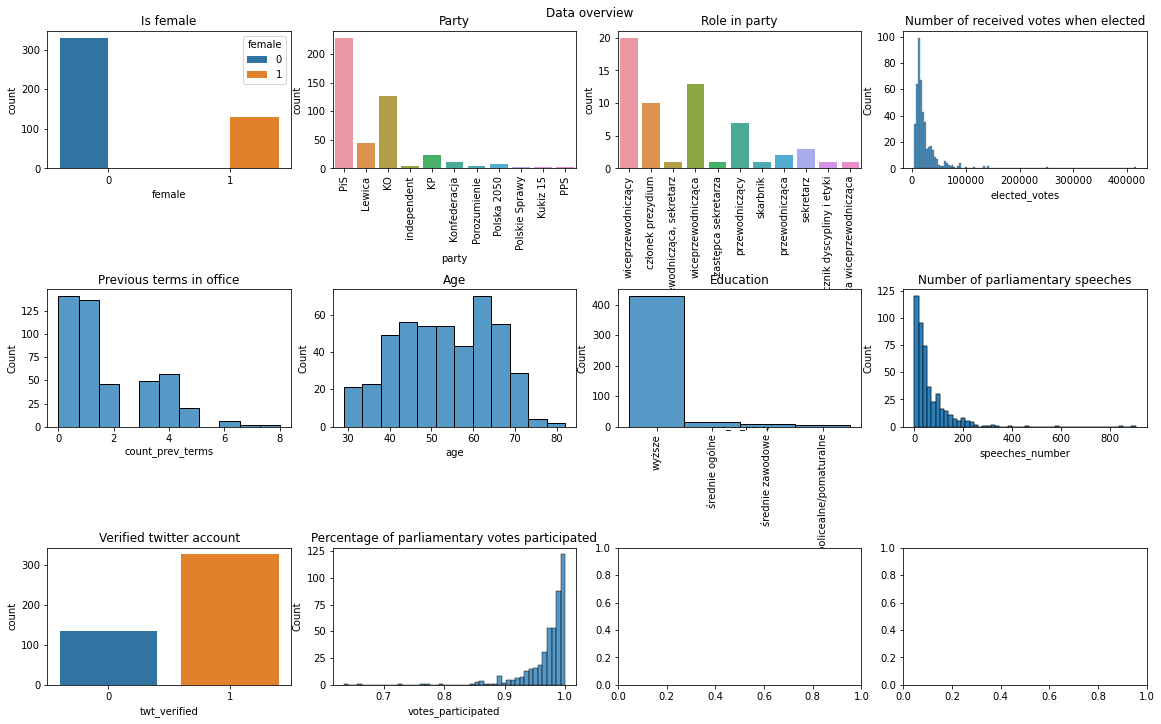

In [229]:
fig, ax = plt.subplots(3, 4, figsize=(16,10))
fig.suptitle('Data overview')
plt.tight_layout(h_pad=10.0)

plt1=sns.countplot(df_joined['female'], ax=ax[0,0], hue=df_joined['female'])
ax[0,0].set_title('Is female')

plt2=sns.countplot(df_joined['party'], ax=ax[0,1])
ax[0,1].set_title('Party')
plt.setp(plt2.get_xticklabels(), rotation=90)

plt3 = sns.countplot(df_joined['role_in_party'], ax=ax[0,2])
ax[0,2].set_title('Role in party')
plt.setp(plt3.get_xticklabels(), rotation=90)

plt4 = sns.histplot(df_joined['elected_votes'], ax=ax[0,3])
ax[0,3].set_title('Number of received votes when elected')

plt5 = sns.histplot(df_joined['count_prev_terms'], ax=ax[1,0])
ax[1,0].set_title('Previous terms in office')

plt5 = sns.histplot(df_joined['age'], ax=ax[1,1])
ax[1,1].set_title('Age')

plt6 = sns.histplot(df_joined['education_level'], ax=ax[1,2])
ax[1,2].set_title('Education')
plt.setp(plt6.get_xticklabels(), rotation=90)

plt7 = sns.histplot(df_joined['speeches_number'], ax=ax[1,3])
ax[1,3].set_title('Number of parliamentary speeches')

plt7 = sns.histplot(df_joined['speeches_number'], ax=ax[1,3])
ax[1,3].set_title('Number of parliamentary speeches')

plt7 = sns.countplot(df_joined['twt_verified'], ax=ax[2,0])
ax[2,0].set_title('Verified twitter account')

plt8 = sns.histplot(df_joined['votes_participated'], ax=ax[2,1])
ax[2,1].set_title('Percentage of parliamentary votes participated')

# plt.xticks(rotation=90)
# plt.xticks(rotation=45)
plt.show()

# ax = sns.histpl
# ot(x=pre_count,discrete=True)
# ax.set(xlabel='Number of Premature Births', ylabel='Number of Realizations')
# plt.title('Number of SODAS people by the cites of most cited work')
# plt.xlabel('Cites of the most cited work')
# plt.ylabel('Number of individuals') -->

##### 12.3 Bivariate plots
Outcome variable - participation in parliamentary votes  
Independent variables - party, number of received votes when elected (excluding outliers that received over 150k votes)

Text(0.5, 1.0, 'Participation in votes by numbers of votes when elected (excluding outliers)')

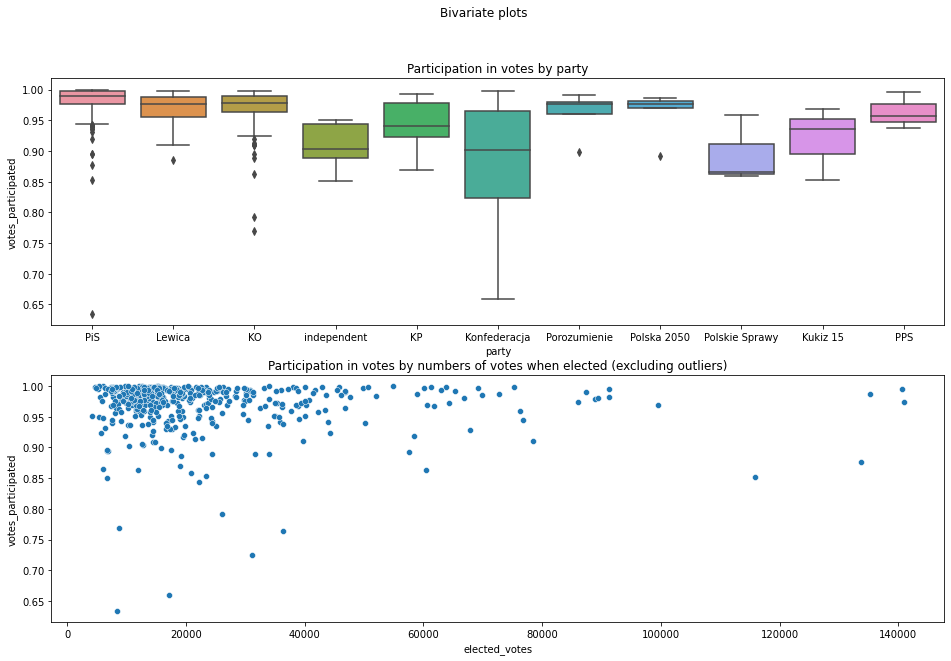

In [240]:
fig, ax = plt.subplots(2, figsize=(16,10))
fig.suptitle('Bivariate plots')

plt1=sns.boxplot(data = df_joined, x='party', y='votes_participated', ax=ax[0])
ax[0].set_title('Participation in votes by party')

plt2=sns.scatterplot(data = df_joined[df_joined['elected_votes']<150000], x='elected_votes', y='votes_participated', ax=ax[1])
ax[1].set_title('Participation in votes by numbers of votes when elected (excluding outliers)')

# plt2=sns.countplot(df_joined['party'], ax=ax[0,1])
# ax[0,1].set_title('Party')
# plt.setp(plt2.get_xticklabels(), rotation=90)

##### 12.4 Linear regression - Twitter followers predicted by number of votes received in election

In [350]:
# Centralising the elected_votes continuous predictor
df_joined = pd.read_csv('df_joined.csv')
df_reg = df_joined.copy()
df_reg['elected_votes'] = df_reg['elected_votes'] - df_reg['elected_votes'].mean()

# Drop rows without twitter accounts
df_reg = df_reg.dropna(subset=['twt_followers'])
df_reg.head(5)

,Unnamed: 0,name,female,party,role_in_party,constituency,elected_votes,prev_terms_in_office,count_prev_terms,birth_date,age,born_city,education_level,profession,speeches_number,speeches_link,votes_participated,votes_link,twt_handle,twt_verified,twt_tweet_count,twt_last_100_tweets_corpus,twt_followers,twt_most_used_words,twt_most_used_word_instances,twt_pis_instances,twt_most_popular_word
0,0,Andrzej Adamczyk,0,PiS,NaN,13 Kraków,4926.682609,"['poseł V kadencji', 'poseł VI kadencji', 'pos...",4,1959-01-04,64,Krzeszowice,wyższe,parlamentarzysta,17,https://www.sejm.gov.pl//Sejm9.nsf/wypowiedzi....,0.9544,https://www.sejm.gov.pl//Sejm9.nsf/agent.xsp?s...,AMAdamczyk,1,15472.0,Odejście Jego Świątobliwości emerytowanego pap...,12611.0,"['odejście', 'infrastruktury', 'httpstcorxhmew...",1.0,0.0,odejście
5,5,Adam Andruszkiewicz,0,PiS,NaN,24 Białystok,5069.682609,['poseł VIII kadencji'],1,1990-06-30,32,Grajewo,wyższe,parlamentarzysta,13,https://www.sejm.gov.pl//Sejm9.nsf/wypowiedzi....,0.9771,https://www.sejm.gov.pl//Sejm9.nsf/agent.xsp?s...,Andruszkiewicz1,1,10444.0,Niesamowite! Wpływowa posłanka opozycji pyta „...,45185.0,"['polska', 'polski', 'premier', 'tuska', 'pola...",5.0,0.0,polska
6,6,Waldemar Andzel,0,PiS,wiceprzewodniczący,32 Katowice,-3036.317391,"['poseł V kadencji', 'poseł VI kadencji', 'pos...",4,1971-09-17,51,Czeladź,wyższe,politolog,196,https://www.sejm.gov.pl//Sejm9.nsf/wypowiedzi....,0.9978,https://www.sejm.gov.pl//Sejm9.nsf/agent.xsp?s...,AndzelWaldemar,1,1360.0,"@iga_swiatek Pani Igo, proszę przyjąć ode mnie...",3428.0,"['️', 'dziękuję', 'kierunekkatar', 'polska', '...",11.0,1.0,ue
7,7,Tomasz Aniśko,0,KO,NaN,8 Zielona Góra,-889.317391,[],0,1963-04-07,59,Ośno Lubuskie,wyższe,architekt krajobrazu,5,https://www.sejm.gov.pl//Sejm9.nsf/wypowiedzi....,0.9807,https://www.sejm.gov.pl//Sejm9.nsf/agent.xsp?s...,AniskoTomasz,1,5859.0,👉 Niestety badanie wody niewiele wykazało. \nW...,1896.0,"['osób', '️', 'mojego', 'laurakwoczala', 'biur...",12.0,0.0,osób
8,8,Jan Krzysztof Ardanowski,0,PiS,NaN,5 Toruń,51507.682609,"['poseł VII kadencji', 'poseł VIII kadencji']",2,1961-02-11,61,Czernikowo,wyższe,inżynier rolnictwa,5,https://www.sejm.gov.pl//Sejm9.nsf/wypowiedzi....,0.9597,https://www.sejm.gov.pl//Sejm9.nsf/agent.xsp?s...,jkardanowski,1,1406.0,Kilka refleksji o rolnictwie na koniec roku i ...,10648.0,"['rolnictwa', 'żywności', 'rolnictwo', 'rolnik...",20.0,5.0,rolnictwa


<AxesSubplot:xlabel='elected_votes', ylabel='twt_followers'>

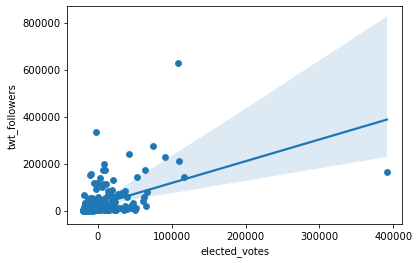

In [353]:
sns.scatterplot(data = df_reg, x='elected_votes', y='twt_followers')
sns.regplot(data = df_reg, x='elected_votes', y='twt_followers')
df_reg[(df_reg['elected_votes'] > -5000) & (df_reg['elected_votes'] < 100000)]

<AxesSubplot:xlabel='elected_votes', ylabel='twt_followers'>

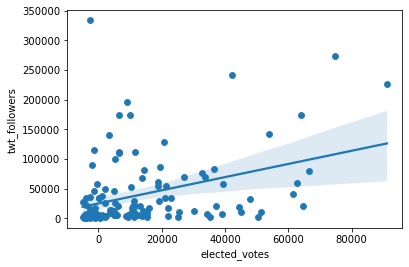

In [372]:
sns.scatterplot(data = df_reg[(df_reg['elected_votes'] > -5000) & (df_reg['elected_votes'] < 100000)], x='elected_votes', y='twt_followers')
sns.regplot(data = df_reg[(df_reg['elected_votes'] > -5000) & (df_reg['elected_votes'] < 100000)], x='elected_votes', y='twt_followers')


Plotted data suggests a positive relationship between the number of votes and twitter followers. However, it also indicates the standard deviation of errors may not be the same for all x values (especially around the outliers) - therefore breaking the assumption of homoscedasticity. Below, I test this using qq plot.

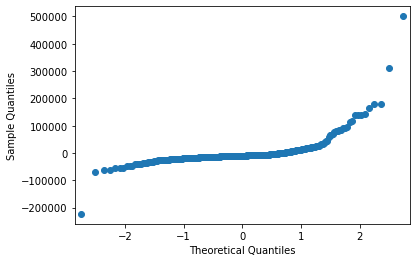

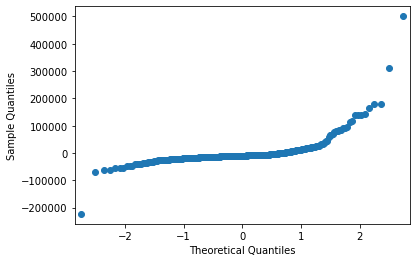

In [354]:
mod1 = ols(data = df_reg, formula='twt_followers~elected_votes').fit()
sm.qqplot(mod1.resid)

As expected, the plot suggests especially heteroscedastic distribution of errors especially outside of a certain range. Below I attempt to exclude some outliers and run a qq plot again.

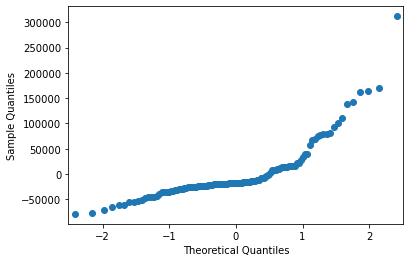

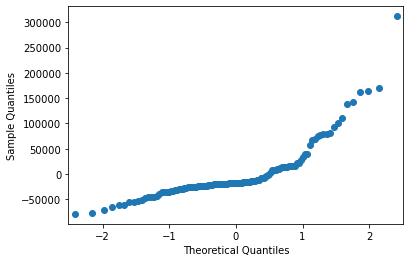

In [368]:
mod1_1 = ols(data = df_reg[(df_reg['elected_votes'] > -5000) & (df_reg['elected_votes'] < 100000)], formula='twt_followers~elected_votes').fit()
sm.qqplot(mod1_1.resid)

Since the distribution of errors still looks irregular, I will run a non-robust and robust linear regressions below and compare the results.

In [364]:
print(mod1.params.round(2))
print(np.sqrt(mod1.scale).round(2))

Stargazer([mod1])

Intercept        24683.95
elected_votes        0.93
dtype: float64
48929.64


In [370]:
mod1.get_robustcov_results(cov_type='HC3').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          twt_followers   R-squared:                       0.245
Model:                            OLS   Adj. R-squared:                  0.243
Method:                 Least Squares   F-statistic:                     1.973
Date:                Sun, 15 Jan 2023   Prob (F-statistic):              0.161
Time:                        20:10:50   Log-Likelihood:                -3981.8
No. Observations:                 326   AIC:                             7968.
Df Residuals:                     324   BIC:                             7975.
Df Model:                           1                                         
Covariance Type:                  HC3                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      2.468e+04   2880.705      8.569      0.000     1.9e+04    3.04e+04
elected_votes     0.9274      0.660      1.405      0.161      -0.371       2.226
==============================================================================
Omnibus:                      362.278   Durbin-Watson:                   2.030
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            23421.946
Skew:                           4.717   Prob(JB):                         0.00
Kurtosis:                      43.439   Cond. No.                     3.00e+04
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
[2] The condition number is large,  3e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In the non-robust regression:  
twt_followers = 24683.95 + 0.93 * elected_votes + e, where E(e) = 0, and SD(e) = 48929.64  
- for every additional vote in election, the number of twitter followers is expected to be larger by 0.93  
- Intercept - in case of having an average number of votes (in this analysis 0), the number of twitter followers is expected to be around 24684
- the influence of elected_votes variable on the outcome is statistically significant   
- I cannot observe any non-linearities, therefore there is no need to use squares predictor terms  

However, the robust model shows that the correlation is more likely not significant.

##### 12.5 Logistic regression - binary variable has_role_in_party predicted by age

Below I run a logistic regression of one having a role in their party predicted by their age. My hypothesis is that the more senior party members will be more likely to have a role in their party.

In [287]:
# Create binary outcome variable has_role_in_party
df_log = df_joined.copy()
df_log['has_role_in_party'] = df_log['role_in_party'].apply(lambda x: int(pd.notnull(x)))
df_log.head()

,name,female,party,role_in_party,constituency,elected_votes,prev_terms_in_office,count_prev_terms,birth_date,age,born_city,education_level,profession,speeches_number,speeches_link,votes_participated,votes_link,twt_handle,twt_verified,twt_tweet_count,twt_last_100_tweets_corpus,twt_followers,twt_most_used_words,twt_most_used_word_instances,twt_pis_instances,twt_most_popular_word,has_role_in_party
0,Andrzej Adamczyk,0,PiS,NaN,13 Kraków,29686,"['poseł V kadencji', 'poseł VI kadencji', 'pos...",4,1959-01-04,64,Krzeszowice,wyższe,parlamentarzysta,17,https://www.sejm.gov.pl//Sejm9.nsf/wypowiedzi....,0.9544,https://www.sejm.gov.pl//Sejm9.nsf/agent.xsp?s...,AMAdamczyk,1,15472.0,Odejście Jego Świątobliwości emerytowanego pap...,12611.0,"['odejście', 'infrastruktury', 'httpstcorxhmew...",1.0,0.0,odejście,0
1,Rafał Adamczyk,0,Lewica,NaN,32 Katowice,12148,[],0,1974-05-30,48,Dąbrowa Górnicza,wyższe,samorządowiec,383,https://www.sejm.gov.pl//Sejm9.nsf/wypowiedzi....,0.9965,https://www.sejm.gov.pl//Sejm9.nsf/agent.xsp?s...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,Piotr Adamowicz,0,KO,NaN,25 Gdańsk,41795,[],0,1961-06-26,61,Elbląg,średnie ogólne,dziennikarz,62,https://www.sejm.gov.pl//Sejm9.nsf/wypowiedzi....,0.9934,https://www.sejm.gov.pl//Sejm9.nsf/agent.xsp?s...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,Romuald Ajchler,0,Lewica,NaN,38 Piła,14438,"['poseł II kadencji', 'poseł III kadencji', 'p...",5,1949-01-19,74,Duszniki Wielkopolskie,średnie zawodowe,rolnik,63,https://www.sejm.gov.pl//Sejm9.nsf/wypowiedzi....,0.9093,https://www.sejm.gov.pl//Sejm9.nsf/agent.xsp?s...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,Zbigniew Ajchler,0,independent,NaN,38 Piła,6654,['poseł VIII kadencji'],1,1955-11-21,67,Szamotuły,wyższe,przedsiębiorca rolny,2,https://www.sejm.gov.pl//Sejm9.nsf/wypowiedzi....,0.8510,https://www.sejm.gov.pl//Sejm9.nsf/agent.xsp?s...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [297]:
# Centralise continuous predictor variable - age
df_log['age'] = df_log['age'] - df_log['age'].mean()
df_log.head()

,name,female,party,role_in_party,constituency,elected_votes,prev_terms_in_office,count_prev_terms,birth_date,age,born_city,education_level,profession,speeches_number,speeches_link,votes_participated,votes_link,twt_handle,twt_verified,twt_tweet_count,twt_last_100_tweets_corpus,twt_followers,twt_most_used_words,twt_most_used_word_instances,twt_pis_instances,twt_most_popular_word,has_role_in_party
0,Andrzej Adamczyk,0,PiS,NaN,13 Kraków,29686,"['poseł V kadencji', 'poseł VI kadencji', 'pos...",4,1959-01-04,10.791304,Krzeszowice,wyższe,parlamentarzysta,17,https://www.sejm.gov.pl//Sejm9.nsf/wypowiedzi....,0.9544,https://www.sejm.gov.pl//Sejm9.nsf/agent.xsp?s...,AMAdamczyk,1,15472.0,Odejście Jego Świątobliwości emerytowanego pap...,12611.0,"['odejście', 'infrastruktury', 'httpstcorxhmew...",1.0,0.0,odejście,0
1,Rafał Adamczyk,0,Lewica,NaN,32 Katowice,12148,[],0,1974-05-30,-5.208696,Dąbrowa Górnicza,wyższe,samorządowiec,383,https://www.sejm.gov.pl//Sejm9.nsf/wypowiedzi....,0.9965,https://www.sejm.gov.pl//Sejm9.nsf/agent.xsp?s...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,Piotr Adamowicz,0,KO,NaN,25 Gdańsk,41795,[],0,1961-06-26,7.791304,Elbląg,średnie ogólne,dziennikarz,62,https://www.sejm.gov.pl//Sejm9.nsf/wypowiedzi....,0.9934,https://www.sejm.gov.pl//Sejm9.nsf/agent.xsp?s...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,Romuald Ajchler,0,Lewica,NaN,38 Piła,14438,"['poseł II kadencji', 'poseł III kadencji', 'p...",5,1949-01-19,20.791304,Duszniki Wielkopolskie,średnie zawodowe,rolnik,63,https://www.sejm.gov.pl//Sejm9.nsf/wypowiedzi....,0.9093,https://www.sejm.gov.pl//Sejm9.nsf/agent.xsp?s...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,Zbigniew Ajchler,0,independent,NaN,38 Piła,6654,['poseł VIII kadencji'],1,1955-11-21,13.791304,Szamotuły,wyższe,przedsiębiorca rolny,2,https://www.sejm.gov.pl//Sejm9.nsf/wypowiedzi....,0.8510,https://www.sejm.gov.pl//Sejm9.nsf/agent.xsp?s...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [311]:
mod2 = smf.logit(formula = 'has_role_in_party ~ age', data = df_log).fit()
Stargazer([mod2])

Optimization terminated successfully.
         Current function value: 0.386493
         Iterations 6


Result not statistically significant, which disproves my hypothesis. Trying a different variable - number of previous terms as a member of parliament as a predictor for whether one has a role in their party. Here I would except those variables to be positively correlated.

In [310]:
mod3 = smf.logit(formula = 'has_role_in_party ~ count_prev_terms', data = df_log).fit()
Stargazer([mod3])

Optimization terminated successfully.
         Current function value: 0.381675
         Iterations 6


<AxesSubplot:xlabel='count_prev_terms', ylabel='has_role_in_party'>

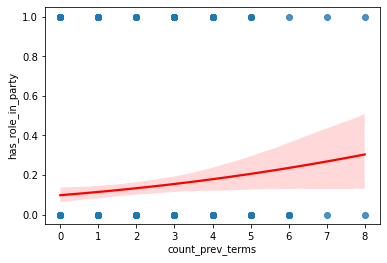

In [294]:
sns.regplot(data = df_log, x='count_prev_terms', y='has_role_in_party', logistic=True, line_kws = {"color":"red"})

Here, the number of previous terms is positively correlated with having a role in a party. For every additional term, the likelihood of having a role in a party is increased by 0.174. The negative intercept value means that with 0 previous terms in office a person is more likely to not have a role in their party. The result is statistically significant.

##### 12.6 Linear regression with control - number of parliamentary speeches predicted by age, controlling for higher_education

<AxesSubplot:xlabel='age', ylabel='speeches_number'>

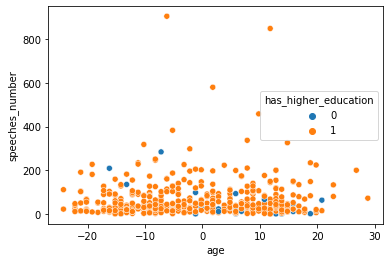

In [371]:
sns.scatterplot(data = df_log, x='age', y='speeches_number', hue='has_higher_education')

In [302]:
# Creating column for binary control variable has_higher_education
df_log['has_higher_education'] = df_log['education_level'].apply(lambda x: int(x=='wyższe'))
df_log.head()

,name,female,party,role_in_party,constituency,elected_votes,prev_terms_in_office,count_prev_terms,birth_date,age,born_city,education_level,profession,speeches_number,speeches_link,votes_participated,votes_link,twt_handle,twt_verified,twt_tweet_count,twt_last_100_tweets_corpus,twt_followers,twt_most_used_words,twt_most_used_word_instances,twt_pis_instances,twt_most_popular_word,has_role_in_party,has_higher_education
0,Andrzej Adamczyk,0,PiS,NaN,13 Kraków,29686,"['poseł V kadencji', 'poseł VI kadencji', 'pos...",4,1959-01-04,10.791304,Krzeszowice,wyższe,parlamentarzysta,17,https://www.sejm.gov.pl//Sejm9.nsf/wypowiedzi....,0.9544,https://www.sejm.gov.pl//Sejm9.nsf/agent.xsp?s...,AMAdamczyk,1,15472.0,Odejście Jego Świątobliwości emerytowanego pap...,12611.0,"['odejście', 'infrastruktury', 'httpstcorxhmew...",1.0,0.0,odejście,0,1
1,Rafał Adamczyk,0,Lewica,NaN,32 Katowice,12148,[],0,1974-05-30,-5.208696,Dąbrowa Górnicza,wyższe,samorządowiec,383,https://www.sejm.gov.pl//Sejm9.nsf/wypowiedzi....,0.9965,https://www.sejm.gov.pl//Sejm9.nsf/agent.xsp?s...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1
2,Piotr Adamowicz,0,KO,NaN,25 Gdańsk,41795,[],0,1961-06-26,7.791304,Elbląg,średnie ogólne,dziennikarz,62,https://www.sejm.gov.pl//Sejm9.nsf/wypowiedzi....,0.9934,https://www.sejm.gov.pl//Sejm9.nsf/agent.xsp?s...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
3,Romuald Ajchler,0,Lewica,NaN,38 Piła,14438,"['poseł II kadencji', 'poseł III kadencji', 'p...",5,1949-01-19,20.791304,Duszniki Wielkopolskie,średnie zawodowe,rolnik,63,https://www.sejm.gov.pl//Sejm9.nsf/wypowiedzi....,0.9093,https://www.sejm.gov.pl//Sejm9.nsf/agent.xsp?s...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
4,Zbigniew Ajchler,0,independent,NaN,38 Piła,6654,['poseł VIII kadencji'],1,1955-11-21,13.791304,Szamotuły,wyższe,przedsiębiorca rolny,2,https://www.sejm.gov.pl//Sejm9.nsf/wypowiedzi....,0.8510,https://www.sejm.gov.pl//Sejm9.nsf/agent.xsp?s...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1


In [322]:
# Linear regression without control

mod4 = ols(data = df_log, formula='speeches_number~age').fit()

Stargazer([mod4])

In [323]:
# Linear regression with control for comparison

mod5 = ols(data = df_log, formula='speeches_number~age+has_higher_education').fit()

Stargazer([mod5])

The age itself is positively correlated with the number of speeches, however not on a significant level.  
Controlling for higher education, the effect of age on the outcome variable is over 4 times stronger, although still not significant. Intercept 64.6 without control is the expected number of speeches of a person of average age. However, controlling for higher education, a person of average age with no higher education is predicted to have spoken 42.7 times on average. There are no clear non-linearities.

##### 12.7 Linear regression with interaction - number of parliamentary speeches predicted by age and higher_education

In [320]:
mod6 = ols(data = df_log, formula='speeches_number~age*has_higher_education').fit()

Stargazer([mod6])

Increase in age predicts a general decrease in number of speeches, however if one has higher education the correlation becomes positive.  
- the intercept here means an expected number of 56 speeches for a person with average age and no higher education
- for each extra year of age withouth higher education, the number of speeches is predicted to be lower by 2.91;  
in the case of having higher education, however, the outcome is predicted to be (3.150 - 2.919) higher for each extra year of age (and 10.309 higher in general)
- speeches_number ~ 56 - 2.919 * age + 3.150 * age * has_higher_education + 10.309 * has_higher_education

These results could be easier to interpret if talking about percentage changes in number of speeches depending on age. Therefore, below I do the same regression on a log-transformed speeches_number variable.


In [377]:
mod6_log = ols("log_speeches~age*has_higher_education", data=df_log).fit()
mod6_log.get_robustcov_results(cov_type='HC3').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           log_speeches   R-squared:                       0.042
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     3.547
Date:                Sun, 15 Jan 2023   Prob (F-statistic):             0.0146
Time:                        21:03:18   Log-Likelihood:                -718.42
No. Observations:                 460   AIC:                             1445.
Df Residuals:                     456   BIC:                             1461.
Df Model:                           3                                         
Covariance Type:                  HC3                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    3.0314      0.353      8.587      0.000       2.338       3.725
age                         -0.0475      0.037     -1.269      0.205      -0.121       0.026
has_higher_education         0.6100      0.357      1.707      0.088      -0.092       1.312
age:has_higher_education     0.0480      0.038      1.273      0.204      -0.026       0.122
==============================================================================
Omnibus:                       12.746   Durbin-Watson:                   2.073
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               13.017
Skew:                          -0.391   Prob(JB):                      0.00149
Kurtosis:                       3.260   Cond. No.                         93.5
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

After log-transforming the speeches number variable, the interpretation is as follows. In case of no higher education, each additional year of age results in a -0.05% percent change in the number of speeches. When one has higher education, the expected number of speeches is higher by 0.61% as a default, and then additional (0.005% = 0.048% - 0.0475%) higher for each additional year of age.

##### 12.9 Linear regression with categorical variable - age dependent on party

In [331]:
df_log.groupby(['party']).mean()

,female,elected_votes,count_prev_terms,age,speeches_number,votes_participated,twt_verified,twt_tweet_count,twt_followers,twt_most_used_word_instances,twt_pis_instances,has_role_in_party,has_higher_education
party,,,,,,,,,,,,,
KO,0.380952,26773.142857,2.063492,0.696066,70.119048,0.967432,0.753968,10768.736842,29315.610526,21.347368,12.589474,0.126984,0.944444
KP,0.125000,15796.833333,2.125000,1.207971,93.750000,0.943292,0.750000,7166.611111,15204.222222,25.166667,6.833333,0.250000,1.000000
Konfederacja,0.000000,25380.083333,0.416667,-9.625362,183.166667,0.875717,0.833333,24257.400000,89904.600000,11.400000,6.600000,0.166667,0.750000
Kukiz 15,0.000000,13937.666667,0.666667,6.124638,62.000000,0.919167,0.666667,767.000000,58791.000000,30.500000,8.500000,0.333333,0.666667
Lewica,0.409091,23207.522727,0.590909,-2.254150,127.250000,0.970375,0.772727,9587.029412,18945.558824,22.970588,7.264706,0.227273,0.977273
PPS,0.333333,29613.333333,1.333333,9.124638,108.000000,0.963867,1.000000,14471.666667,31055.333333,18.000000,6.666667,0.333333,0.666667
PiS,0.236842,25583.942982,1.736842,0.300076,35.469298,0.981568,0.644737,7504.244898,20030.040816,18.198630,1.746575,0.092105,0.916667
Polska 2050,0.428571,24007.285714,1.142857,-1.780124,274.571429,0.965571,1.000000,14797.428571,26621.857143,38.714286,6.000000,0.142857,1.000000
Polskie Sprawy,0.333333,13077.000000,2.333333,2.457971,24.000000,0.894333,0.666667,3491.000000,15155.000000,12.500000,0.500000,0.333333,1.000000


In [337]:
mod7 = smf.logit(formula = 'has_higher_education ~ C(party, Treatment(reference="KO"))', data = df_log).fit()
# mod7 = ols(data = df_log, formula='speeches_number~age*has_higher_education').fit()
Stargazer([mod7])

         Current function value: 0.234310
         Iterations: 35


/Users/aleksygalkowski/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Using the above analysis, I can draw a conclusion that being in one of these parties: Konfederacja, Kukiz, or PPS, results in a statistically significant decrease in the likelihood of having higher education relative to the reference party - KO. The intercept refers to the likelihood of a KO party member to have higher education, which is significantly high - 94% of their members have higher education.